In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Neural style transfer
### Original sources for code + explanation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image. This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.).


Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

## Setup


### Import and configure modules

In [10]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [11]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import cv2

In [12]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [13]:
# content_path = tf.keras.utils.get_file('arches_park.jpg', 'https://upload.wikimedia.org/wikipedia/commons/f/f0/Delicate_arch_sunset.jpg')
# content_path = tf.keras.utils.get_file('desert_night.jpg', 'https://i.ytimg.com/vi/eD-uW422fB0/maxresdefault.jpg')
content_path = '/content/insta_024.jpg'

# style_path = tf.keras.utils.get_file('mona-lisa.png', 'https://cdn.britannica.com/24/189624-050-F3C5BAA9/Mona-Lisa-oil-wood-panel-Leonardo-da.jpg')
# style_path = tf.keras.utils.get_file('signac.jpg', 'https://upload.wikimedia.org/wikipedia/commons/3/3a/Signac_-_Portrait_de_F%C3%A9lix_F%C3%A9n%C3%A9on.jpg')
style_path = tf.keras.utils.get_file('scream.jpg', 'https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg')
# style_path = tf.keras.utils.get_file('gogh.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Vincent_van_Gogh_%281853-1890%29_Caf%C3%A9terras_bij_nacht_%28place_du_Forum%29_Kr%C3%B6ller-M%C3%BCller_Museum_Otterlo_23-8-2016_13-35-40.JPG/540px-Vincent_van_Gogh_%281853-1890%29_Caf%C3%A9terras_bij_nacht_%28place_du_Forum%29_Kr%C3%B6ller-M%C3%BCller_Museum_Otterlo_23-8-2016_13-35-40.jpg')
# style_path = tf.keras.utils.get_file('pearl.jpg', 'https://www.singulart.com/blog/wp-content/uploads/2023/10/Famous-Portrait-Paintings-848x530-1.jpg')

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [14]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [15]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

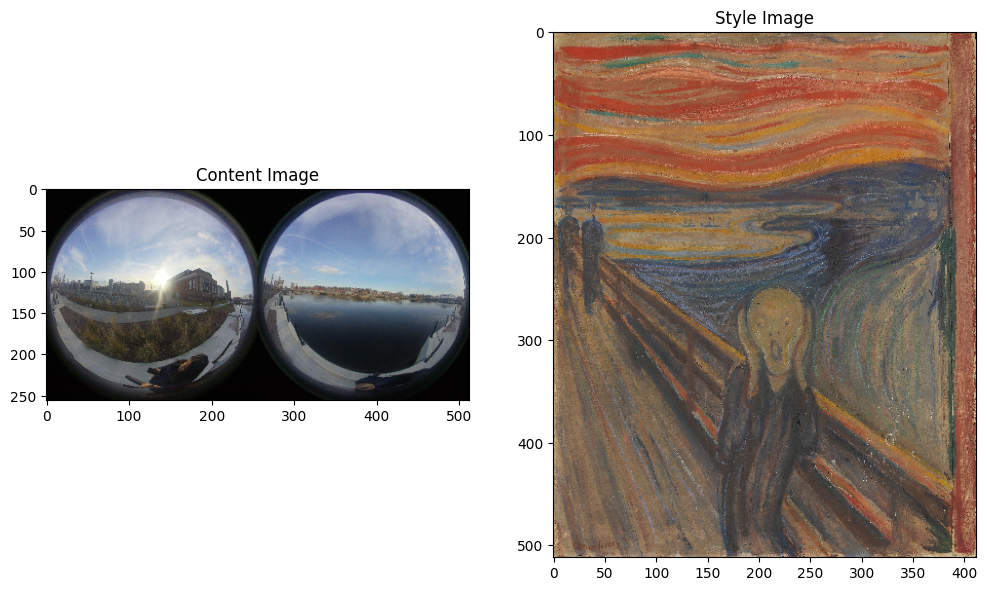

In [16]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

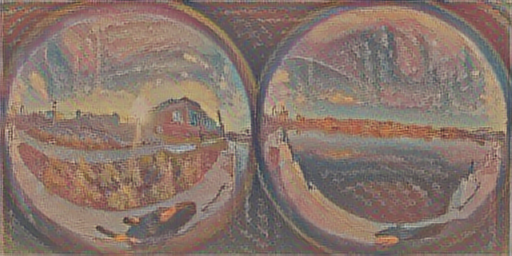

In [17]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [18]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 17s 0us/step


TensorShape([1, 1000])

In [19]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('spotlight', 0.36525738),
 ('barrel', 0.19322087),
 ('viaduct', 0.1873136),
 ('grille', 0.06478437),
 ('car_mirror', 0.024564715)]

Now load a `VGG19` without the classification head, and list the layer names

In [20]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 2s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [21]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [22]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [23]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [24]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [25]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [26]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [27]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [28]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [29]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [30]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [31]:
style_weight=1e-2
content_weight=1e4

In [32]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [33]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Perform the optimization:

In [34]:
def generate_image(epochs, steps_per_epoch, image):
    start = time.time()
    step = 0

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='', flush=True)

        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))

    end = time.time()
    print("Total time: {:.1f}".format(end - start))

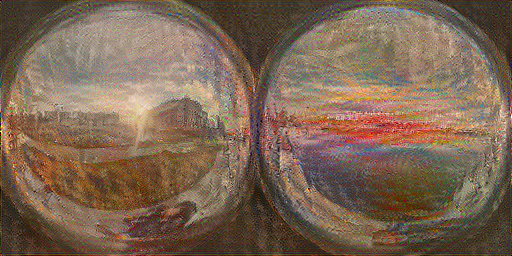

Train step: 700
Total time: 34.7


In [35]:
epochs = 7
steps_per_epoch = 100

generate_image(epochs, steps_per_epoch, image)
old_image = image

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [36]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [37]:
total_variation_weight=100

Now include it in the `train_step` function:

In [38]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

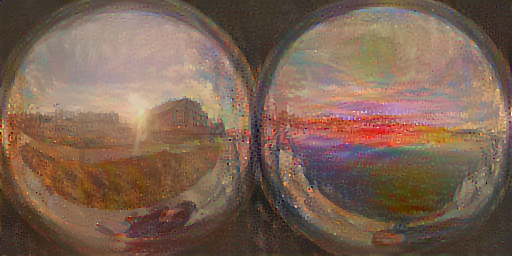

Train step: 700
Total time: 32.6


In [40]:
epochs = 7
steps_per_epoch = 100

generate_image(epochs, steps_per_epoch, image)

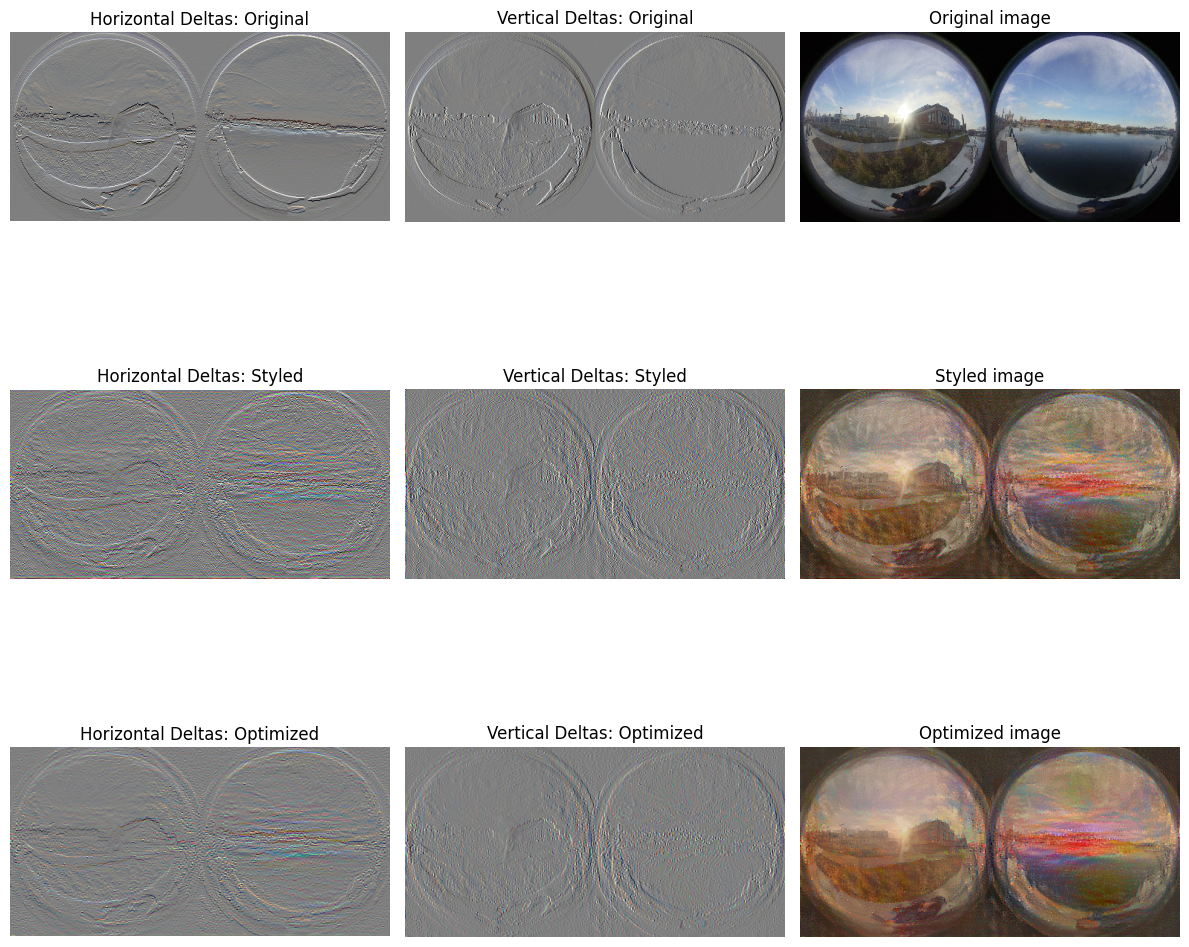

In [41]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), tight_layout=True)

img = content_image
x_deltas, y_deltas = high_pass_x_y(img)
axs[0, 0].imshow(clip_0_1(2*y_deltas+0.5)[0])
axs[0, 0].set_title("Horizontal Deltas: Original")
axs[0, 0].axis("off")
axs[0, 1].imshow(clip_0_1(2*x_deltas+0.5)[0])
axs[0, 1].set_title("Vertical Deltas: Original")
axs[0, 1].axis("off")
axs[0, 2].imshow(img[0])
axs[0, 2].set_title("Original image")
axs[0, 2].axis("off")

img = old_image
x_deltas, y_deltas = high_pass_x_y(img)
axs[1, 0].imshow(clip_0_1(2*y_deltas+0.5)[0])
axs[1, 0].set_title("Horizontal Deltas: Styled")
axs[1, 0].axis("off")
axs[1, 1].imshow(clip_0_1(2*x_deltas+0.5)[0])
axs[1, 1].set_title("Vertical Deltas: Styled")
axs[1, 1].axis("off")
axs[1, 2].imshow(img[0])
axs[1, 2].set_title("Styled image")
axs[1, 2].axis("off")

img = image
x_deltas, y_deltas = high_pass_x_y(img)
axs[2, 0].imshow(clip_0_1(2*y_deltas+0.5)[0])
axs[2, 0].set_title("Horizontal Deltas: Optimized")
axs[2, 0].axis("off")
axs[2, 1].imshow(clip_0_1(2*x_deltas+0.5)[0])
axs[2, 1].set_title("Vertical Deltas: Optimized")
axs[2, 1].axis("off")
axs[2, 2].imshow(img[0])
axs[2, 2].set_title("Optimized image")
axs[2, 2].axis("off")

plt.show()

This shows how the high frequency components increased with the stylization, but is lowered with the optimization of the loss using total variation.

NOTE: This high frequency component is basically an edge-detector.

In [80]:
# Function to create the mask for the image
def create_mask(image_path, threshold=0.5):
    img = load_img(image_path)

    # Convert the image to a NumPy array
    image_array = tf.keras.preprocessing.image.img_to_array(img[0])

    # Convert the image to grayscale
    gray_image = tf.image.rgb_to_grayscale(image_array)

    # Create a binary mask based on intensity threshold
    binary_mask = tf.where(gray_image > threshold, 1.0, 0.0)

    return binary_mask

# Function to apply the mask to the image
def apply_mask(img, mask):
    return img[0] * mask + content_image[0] * (1 - mask)

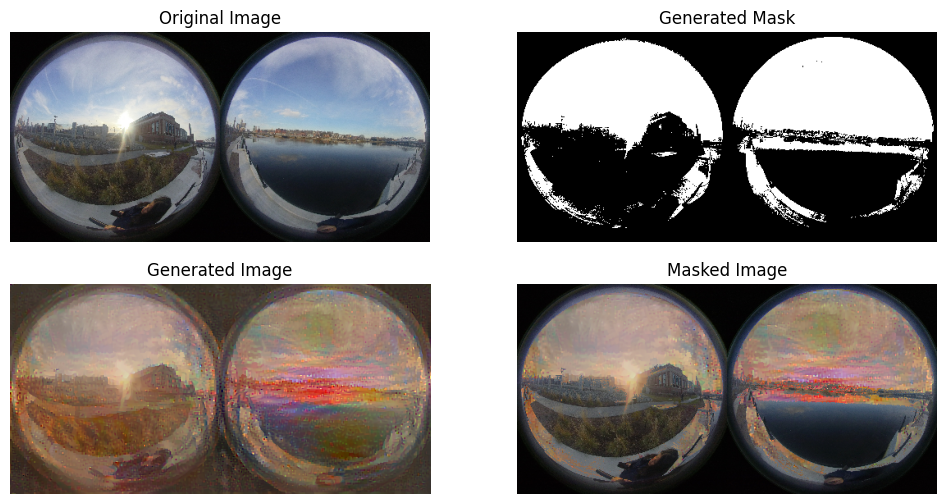

In [88]:
image_path = '/content/insta_024.jpg'
mask = create_mask(image_path, 0.45)

# Display the original image and the created mask

new_image = apply_mask(image, mask)

# Display the original image and the created mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(content_image[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Generated Mask')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(image[0])
plt.title('Generated Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(new_image, cmap='gray')
plt.title('Masked Image')
plt.axis('off')


plt.show()

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Learn more

This tutorial demonstrates the original style-transfer algorithm. For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the arbitrary image style transfer model from [TensorFlow Hub](https://tfhub.dev).